In [476]:
'''
HW PROB 1
helpful: https://www.youtube.com/watch?v=_PDyi5BVY-E
            https://www.youtube.com/watch?v=nKd0lu3yThg
'''

import warnings
import numpy as np
import matplotlib.pyplot as plt

class SpectralDecompositionPowerMethod:
    """
    Store the output vector in the object attribute self.components_ and the 
    associated eigenvalue in the object attribute self.stored_eigenvalues 
    
    Why this code structure and attribute names? We are using the convention used by 
    the popular scikit-learn machine learning library:
    https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

    Parameters
        max_iter (int): maximum number of iterations to for the calculation
        tolerance (float): fractional change in solution to stop iteration early
        gamma (float): momentum parameter for the power method
        random_state (int): random seed for reproducibility
        store_intermediate_results (bool): whether to store the intermediate results as
            the power method iterates
        stored_eigenvalues (list): If store_intermediate_results is active, a list of 
            eigenvalues at each iteration
        stored_eigenvectors (list): If store_intermediate_results is active, a list of
            eigenvectors at each iteration
    
    """
    def __init__(self, 
        max_iter=1000, 
        tolerance=1e-10, 
        gamma=0.0,
        random_state=None, 
        store_intermediate_results=False
    ):
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.gamma = gamma
        self.components_ = []
        self.stored_eigenvalues = []
        self.singular_values_ = None
            
    def fit(self, A):
        """
        Perform the power method with random initialization, and optionally store
        intermediate estimates of the eigenvalue and eigenvectors at each iteration.
        You can add an early stopping criterion based on the tolerance parameter.
        """
        w = np.zeros(A.shape[0])
        w[0] = 1
        
        i = 0
        
        self.components_.append(np.dot(A, w))
        
        ## No Momentum
        self.components_.append(np.dot(A, self.components_[-1]))
        
        ## MOMENTUM:
#         self.components_.append(self.gamma*self.components_[-1] + (1-self.gamma)*(np.dot(A, self.components_[-1])))
        
        self.stored_eigenvalues.append(np.dot(self.components_[-2], self.components_[-1])/np.dot(self.components_[-2], self.components_[-2]))

        diff = 1 
        while diff > self.tolerance:
            if i > self.max_iter:
                print("max iteration exceeded: BREAK")
                break
            i+=1
            
            ## No Momentum
            self.components_.append(np.dot(A, self.components_[-1]))
            
            ## Momentum
#             self.components_.append(self.gamma*self.components_[-1] + (1-self.gamma)*(np.dot(A, self.components_[-1])))
            
            self.stored_eigenvalues.append(np.dot(self.components_[-2], self.components_[-1])/np.dot(self.components_[-2], self.components_[-2]))
            diff = np.absolute(self.stored_eigenvalues[-1] - self.stored_eigenvalues[-2])

        eigVal = np.dot(self.components_[-2], self.components_[-1])/np.dot(self.components_[-2], self.components_[-2])
        eigVec = self.components_[-1]
        singular_values_ = np.array(self.stored_eigenvalues)
        print(eigVal)
        
        return self

In [475]:
n = 100
mat = SpectralDecompositionPowerMethod()

B = np.random.randint(100, size=(n,n))
mat.fit(B)

print("\nCHECK with np.linalg.eigvals(B)[0]:")
print(np.real(np.linalg.eigvals(B)[0]))



"""
2. I wasn't able to get anything that didn't give a correct solution, but my guess would be that a randomly generated matrix is
    not guaranteed to be full-rank which is a requirement for this to work.
4. momentum commented out, but it is there

Right now I don't fully understand the dynamics portion.
"""

4937.1025192614725

CHECK with np.linalg.eigvals(B)[0]:
4937.10251926147


"\n2. I wasn't able to get anything that didn't give a correct solution, but my guess would be that a randomly generated matrix is\n    not guaranteed to be full-rank which is a requirement for this to work.\n3. \n"

In [ ]:
Re = 1200 # Reynolds number, change this to 300, 600, 900, 1200

# Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
# where the first dimension is the time index, the second and third dimensions are the
# x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
vfield = np.load(
    f"../resources/von_karman_street/vortex_street_velocities_Re_{Re}_largefile.npz", 
    allow_pickle=True
)
print("Velocity field data has shape: {}".format(vfield.shape))

# Calculate the vorticity, which is the curl of the velocity field
vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0] 

In [495]:
"""
Prob 2
https://www.youtube.com/watch?v=fkf4IBRSeEc
"""

from sklearn.base import BaseEstimator, TransformerMixin

# We are going to use class inheritance to define our object. The two base classes from
# scikit-learn represent placeholder objects for working with datasets. They include 
# many generic methods, like fetching parameters, getting the data shape, etc.
# 
# By inheriting from these classes, we ensure that our object will have access to these
# functions, even though we don't have to define them ourselves
class PrincipalComponents(BaseEstimator, TransformerMixin):
    """
    A class for performing principal component analysis on a dataset.
    """

    def __init__(self, random_state=None):
        self.random_state = random_state
        self.components_ = None
        self.stored_eigenvalues = None

    def fit(self, X):
        """
        Fit the PCA model to the data X. Store the eigenvectors in the attribute
        self.components_ and the eigenvalues in the attribute self.stored_eigenvalues

        Args:
            X (np.ndarray): A 2D array of shape (n_samples, n_features) containing the
                data to be fit.
        
        Returns:
            self (PrincipalComponents): The fitted object.
        """

        Xc = X - np.mean(X, axis=0)
        sigma = (1/np.shape(X)[0]) * np.dot(np.transpose(X), X)
        S, V = np.linalg.eigh(sigma)
        
        sort_inds = np.argsort(S)[::-1]
        S, V = S[sort_inds], V[sort_inds]
        
        self.components_ = V
        self.stored_eigenvalues = S
#         print(self.stored_eigenvalues)
        
        return self
    
    def transform(self, X):
        """
        Transform the data X into the new basis using the PCA components
        """
        
        Xc = X - np.mean(X, axis=0)
        
        return np.dot(np.transpose(self.components_), Xc)

    def inverse_transform(self, X):
        """
        Transform from principal components space back to the original space
        """
        return np.dot(np.transpose(self.components_), X) - np.mean(X, axis=0)


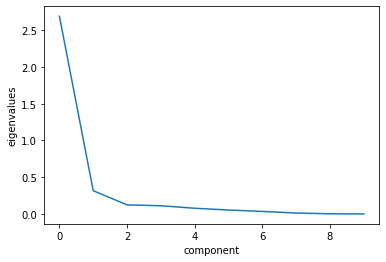

In [505]:
n = 10
a = PrincipalComponents()
x = np.random.rand(n,n)
a.fit(x)

plt.plot(a.stored_eigenvalues)
plt.ylabel("eigenvalues")
plt.xlabel("component")
plt.show()


In [ ]:
# Load William's solutions
from solutions.pca import PrincipalComponents

data = np.copy(vort_field)[::3, ::2, ::2] # subsample data to reduce compute load
data_reshaped = np.reshape(data, (data.shape[0], -1))

model = PrincipalComponents()
# model = PCA()

data_transformed = model.fit_transform(data_reshaped)
principal_components = np.reshape(
    model.components_, (model.components_.shape[0], data.shape[1], data.shape[2])
)

## Look at skree plot, and identify the "elbow" indicating low dimensionality
plt.figure()
plt.plot(model.singular_values_[:50])
plt.plot(model.singular_values_[:50], '.')
plt.xlabel("Eigenvalue magnitude")
plt.ylabel("Eigenvalue rank")

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    vscale = np.percentile(np.abs(principal_components[i]), 99)
    plt.imshow(principal_components[i], cmap="RdBu", vmin=-vscale, vmax=vscale)
    plt.title("PC {}".format(i+1))

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(8, 1, i+1)
    plt.plot(data_transformed[:, i])
    plt.ylabel("PC {} Amp".format(i+1))
plt.xlabel("Time")

plt.figure()
ax = plt.axes(projection='3d')
ax.plot(data_transformed[:, 0], data_transformed[:, 1], data_transformed[:, 2])